<a href="https://colab.research.google.com/github/ashley-ferreira/PHYS449_FinalProject/blob/main/notebooks/Feature_Maps_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**These cells allow for the visualization of the original galaxy images, and the extraction of the feature maps at each convolutional layer in the C1 and C2 4-way classification models.**

In [1]:
#Import Modules:
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.preprocessing import image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Conv2D, MaxPool2D
from keras.layers.core import Dropout

import tensorflow as tf
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

#Import google drive (need to put data folder as shortcut in your local drive My Drive):
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#This loads the data from the txt file:
#Remember to change required path to access the data
def data_batch(datafile_index, num_images=10, data_file='/content/drive/MyDrive/Final Project/data/data_g_band_v2.txt'):
    '''
    Description:
        Access datafile.txt, each row is flattened 110x110 image + 1 label string (E, Sp, S0, Irr+Misc).
        Returns an augmented batch of num_images X 40.
        The labels are converted to 1D vectors (ex: Sp = [0,0,1,0])
        Need to give a datafile_index that tells which rows to pick.
    Inputs:
        datafile_index: index of row in datafile to load. loads rows datafile_index to datafile_index+num_images.
        num_images: number of different images to load per batch, total batch size 
        is 40 X num_images. (default: 10 (for 40X10 = 400 batch size like in paper)
        data_file: datafile full path, need to add shortcut to local Drive. (default: '/content/drive/MyDrive/Final Project/data/data_g_band_v2.txt')
    Outputs:
        tensor_input_batch_aug: dimensions: (100, 100, num_images X 40). 
        tensor_label_batch_aug: dimensions: (num_images X 40, 4)
    '''

    #Take batch of num_images rows from datafile:
    with open(data_file, 'r') as f:
        rows = f.readlines()[datafile_index:(datafile_index+num_images)]

    #For batch size of 400 (augmented), need 10 images
    data_batch = np.zeros((num_images,12101), dtype=np.dtype('U10'))
    count = 0
    for row in rows:
        data_batch[count,:] = row.split()
        count += 1

    #Separate label and input:
    input_batch_flat = np.array(data_batch[:,:12100], dtype=int)
    label_batch = np.array(data_batch[:,-1])

    #Convert input batch back to a 2D array:
    input_batch = np.empty((110,110,np.shape(input_batch_flat)[0]), dtype=int)
    for ii in range(np.shape(input_batch_flat)[0]):
        input_batch[:,:,ii] = np.reshape(input_batch_flat[ii,:], (110,110))


    #Convert label batch into into 1D vector: 
    #E=0, S0=1, Sp=2, Irr+Misc=3
    #ex: label = [0,0,1,0] ==> Sp galagy
    arr_label_batch = np.empty((np.shape(label_batch)[0],4), dtype=int)
    arr_label_batch[:,0] = np.array([label_batch == 'E'], dtype=int)
    arr_label_batch[:,1] = np.array([label_batch == 'Sp'], dtype=int)
    arr_label_batch[:,2] = np.array([label_batch == 'S0'], dtype=int)
    arr_label_batch[:,3] = np.array([label_batch == 'Irr+Misc'], dtype=int)

    #NOW AUGMENT THE BATCH (40X more):
    input_batch_aug = np.empty((100,100,np.shape(input_batch)[2]*40), dtype=int)
    arr_label_batch_aug = np.empty((np.shape(arr_label_batch)[0]*40, 4), dtype=int)

    count = 0
    for ll in range(np.shape(input_batch)[2]):
        #Crop 5X more image (100X100 pixels)
        C1 = input_batch[:100,:100,ll]
        C2 = input_batch[10:,:100,ll]
        C3 = input_batch[:100,10:,ll]
        C4 = input_batch[10:,10:,ll]
        C5 = input_batch[5:105,5:105,ll]

        C = [C1, C2, C3, C4, C5]

        for kk in range(5):
            #Rotate 4X more image (by 90 deg)
            for jj in range(4):
                C_R = np.rot90(C[kk], k=jj)
                input_batch_aug[:,:,count] = C_R
                arr_label_batch_aug[count,:] = arr_label_batch[ll,:]
                count += 1
                
                input_batch_aug[:,:,count] = np.swapaxes(C_R,0,1)
                arr_label_batch_aug[count,:] = arr_label_batch[ll,:]
                count += 1


    #PUT THE DATA AS A PYTORCH TENSOR:
    tensor_input_batch_aug = torch.Tensor(input_batch_aug)
    tensor_label_batch_aug = torch.Tensor(arr_label_batch_aug)
    
    return tensor_input_batch_aug, tensor_label_batch_aug


75


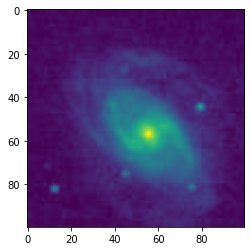

76


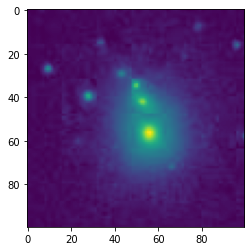

77


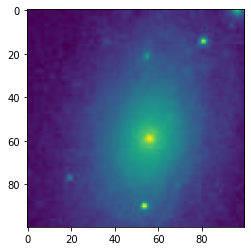

78


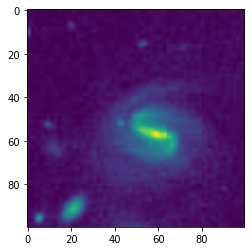

79


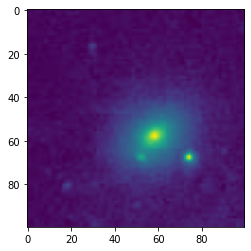

In [3]:
#This allows for visualisation of the original images:
#Setting a range of indices of the images that are desired to be viewed
rand_index = np.arange(75,80,1)
rand_train = rand_index[:]

#This loops through the desired range in the dataset and plots each image
for ii in range(np.shape(rand_train)[0]):
  image_batch, label_batch = data_batch(datafile_index=rand_train[ii], num_images=len(rand_train))
  print(rand_train[ii]) #Prints the image index
  plt.grid  ( False )
  plt.imshow( image_batch[:,:,0], aspect=1, cmap='viridis' )
  plt.show()


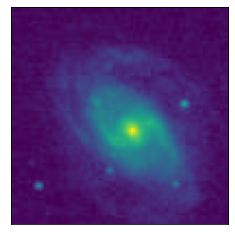

In [4]:
#Once desired image is found, input its index below to isolate the image
image_batch, label_batch = data_batch(datafile_index=75, num_images=1)
plt.grid  ( False )
plt.imshow( image_batch[:,:,0], aspect=1, cmap='viridis' )
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
#This sets the number of classes
num_classes = 4

In [6]:
#This is the pytorch C1 model
networkc1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(135424,256),
    nn.ReLU(),
    nn.Linear(256, num_classes))

In [7]:
#This is the keras C1 model
modelc1 = Sequential()
modelc1.add(Conv2D(32, kernel_size=(5, 5), input_shape=(100,100,1), activation='relu', padding='same'))
modelc1.add(BatchNormalization())
modelc1.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
modelc1.add(BatchNormalization())
modelc1.add(MaxPool2D(pool_size=(2, 2)))
modelc1.add(Flatten())
modelc1.add(Dropout(0.5))
modelc1.add(Dense(256, activation='relu'))
modelc1.add(Dense(4, activation='softmax'))
modelc1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      832       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      51264     
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                        

In [8]:
#This is the pytorch C2 model
networkc2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=7, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(64),

    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(8192, 256),
    nn.Dropout(0.5),

    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256, num_classes))

In [9]:
#This is the keras C2 model
modelc2 = Sequential()
modelc2.add(Conv2D(32, kernel_size=(7, 7), input_shape=(100,100,1), activation='relu', padding='same'))
modelc2.add(BatchNormalization())
modelc2.add(MaxPool2D(pool_size=(2, 2)))
modelc2.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
modelc2.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
modelc2.add(BatchNormalization())
modelc2.add(MaxPool2D(pool_size=(2, 2)))
modelc2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
modelc2.add(BatchNormalization())
modelc2.add(MaxPool2D(pool_size=(2, 2)))
modelc2.add(Flatten())
modelc2.add(Dropout(0.5))
modelc2.add(Dense(256, activation='relu'))
modelc2.add(Dense(256, activation='relu'))
modelc2.add(Dense(10, activation='softmax'))
modelc2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      1600      
                                                                 
 batch_normalization_2 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        51264     
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        102464    
                                                                 
 batch_normalization_3 (Batc  (None, 50, 50, 64)      

In [10]:
#This prints the layer names for C1
layer_names = [layer.name for layer in modelc1.layers]
layer_names

['conv2d',
 'batch_normalization',
 'conv2d_1',
 'batch_normalization_1',
 'max_pooling2d',
 'flatten',
 'dropout',
 'dense',
 'dense_1']

In [11]:
#This prints the layer names for C2
layer_names = [layer.name for layer in modelc2.layers]
layer_names

['conv2d_2',
 'batch_normalization_2',
 'max_pooling2d_1',
 'conv2d_3',
 'conv2d_4',
 'batch_normalization_3',
 'max_pooling2d_2',
 'conv2d_5',
 'batch_normalization_4',
 'max_pooling2d_3',
 'flatten_1',
 'dropout_1',
 'dense_2',
 'dense_3',
 'dense_4']

In [12]:
#This takes the image, processes it, and finds the representations for it throughout the desired model
#Set the desired model here:
desired_model = modelc2
successive_outputs = [layer.output for layer in desired_model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = desired_model.input, outputs = successive_outputs)

x = image_batch[:,:,0].detach().cpu().numpy()#images[111]                 # Numpy array with shape (150, 150, 3)
print(x.shape)
print(type(x))
x = x.reshape((1,) + x.shape)   # Numpy array with shape (1, 150, 150, 3)

# Rescale the image by 1/255
x /= 255.0

# We run the image through the NN and get all the intermediate representations for the image
successive_feature_maps = visualization_model.predict(x)

# Getting the names of the layers to call upon later
layer_names = [layer.name for layer in desired_model.layers]

(100, 100)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 294ms/step


conv2d_2


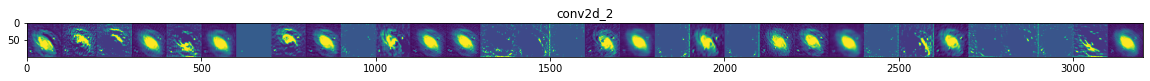

conv2d_3


<ipython-input-13-8049d907c256>:19: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


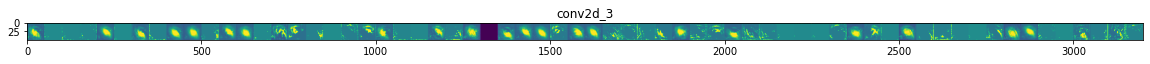

conv2d_4


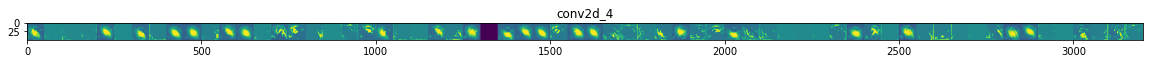

conv2d_5


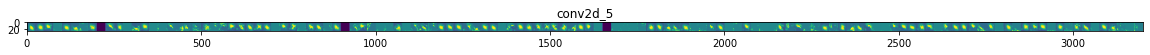

In [13]:
#Saving the names of the lists of the images 
conv2d_list = []
conv2d1_list = []
conv2d2_list = []
conv2d3_list = []
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4 and ('conv2d' in layer_name):
        # We just want the maps for the conv layers, not the maxpool or fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
        # The images will be tiled in this matrix
        display_grid = np.zeros((size, size * n_features))

        # Altering the feature maps to be more visually understandable
        print(layer_name)
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8') #Saves the individual image
            display_grid[:, i * size : (i + 1) * size] = x # Combine all the maps into a long horizontal image
            #Saving the individual maps by layer
            if (layer_name == 'conv2d'):
                conv2d_list.append(x) #Takes the individual maps for the layer
                split = np.array(np.hsplit(display_grid, 4))
                conv2d_grid = np.array(np.vstack(split)) #Rearranges the images to desired grid shape that matches paper
            if (layer_name == 'conv2d_1'):
                conv2d1_list.append(x)
                split = np.array(np.hsplit(display_grid, 4))
                conv2d1_grid = np.array(np.vstack(split))
            #These bottom are for C2, above is for C1
            if (layer_name == 'conv2d_2'):
                conv2d_list.append(x)
                split = np.array(np.hsplit(display_grid, 4))
                conv2d_grid = np.array(np.vstack(split))
            if (layer_name == 'conv2d_3'):
                conv2d1_list.append(x)
                split = np.array(np.hsplit(display_grid, 4))
                conv2d1_grid = np.array(np.vstack(split))
            if (layer_name == 'conv2d_4'):
                conv2d2_list.append(x)
                split = np.array(np.hsplit(display_grid, 4))
                conv2d2_grid = np.array(np.vstack(split))
            if (layer_name == 'conv2d_5'):
                conv2d3_list.append(x)
                split = np.array(np.hsplit(display_grid, 8))
                conv2d3_grid = np.array(np.vstack(split))            

        # Display all the horizontal convolutional grid feature maps
        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' )
        plt.show()


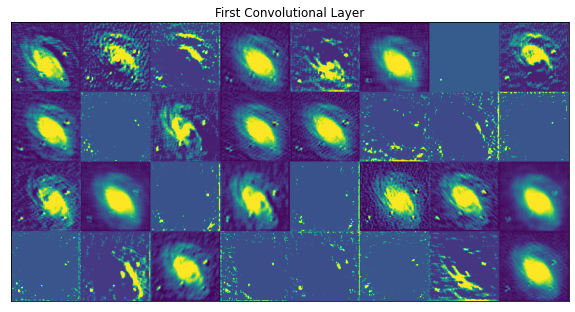

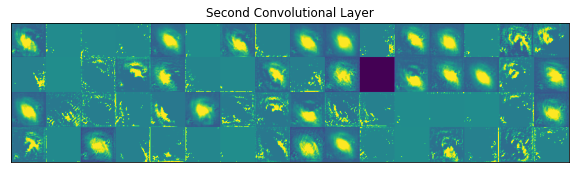

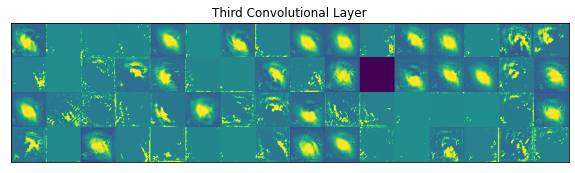

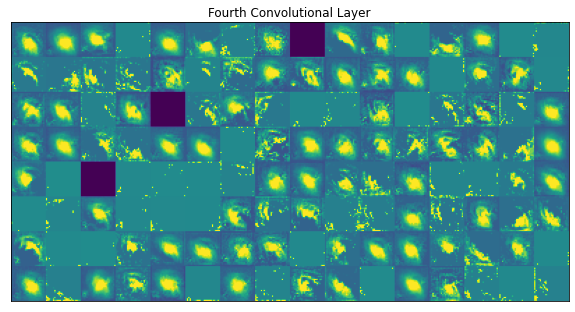

In [14]:
#This plots the feature maps from each convolutional layer as a single block
if desired_model == modelc1:
    plt.figure(figsize=(10, 10))
    plt.title('First Convolutional Layer')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(conv2d_grid, aspect=1, cmap='viridis')
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.title('Second Convolutional Layer')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(conv2d1_grid, aspect=1, cmap='viridis')
    plt.show()
if desired_model == modelc2:
    plt.figure(figsize=(10, 10))
    plt.title('First Convolutional Layer')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(conv2d_grid, aspect=1, cmap='viridis')
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.title('Second Convolutional Layer')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(conv2d1_grid, aspect=1, cmap='viridis')
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.title('Third Convolutional Layer')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(conv2d2_grid, aspect=1, cmap='viridis')
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.title('Fourth Convolutional Layer')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(conv2d3_grid, aspect=1, cmap='viridis')
    plt.show()

conv2d_2


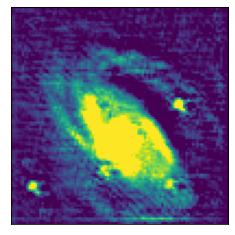

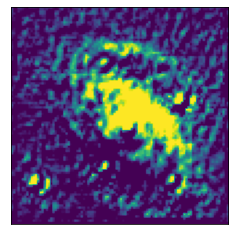

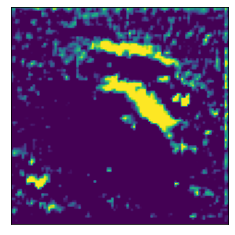

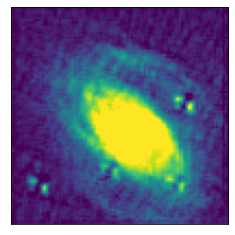

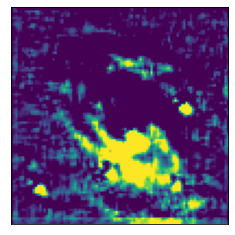

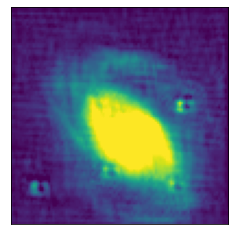

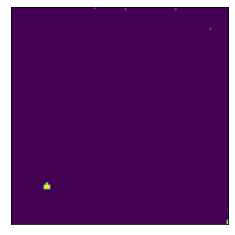

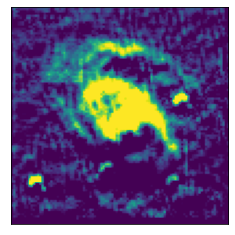

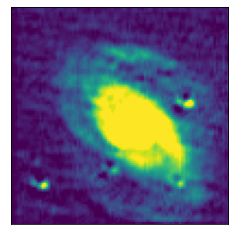

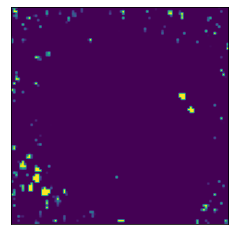

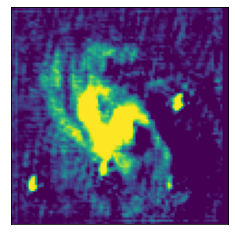

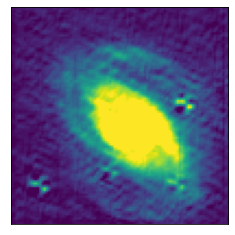

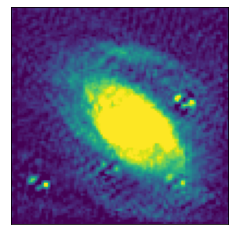

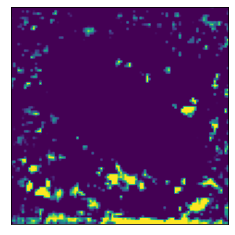

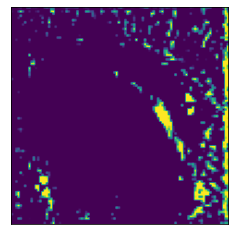

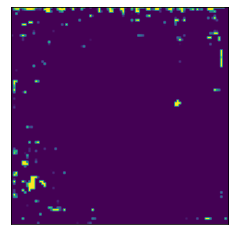

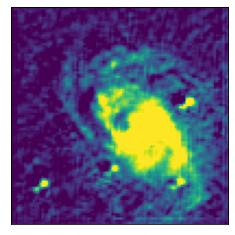

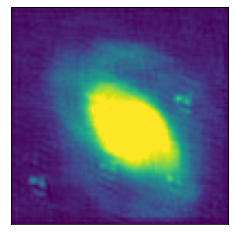

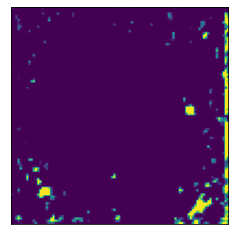

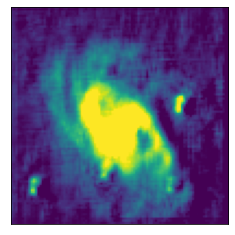

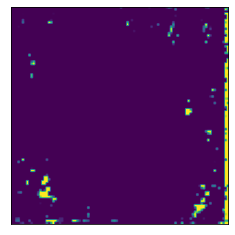

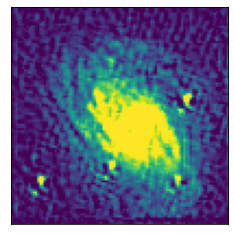

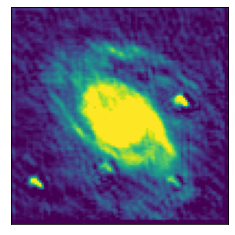

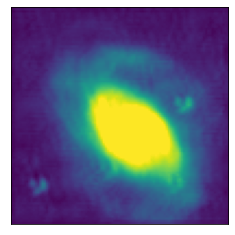

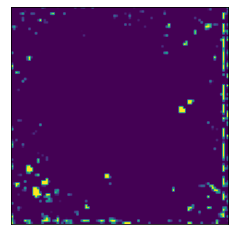

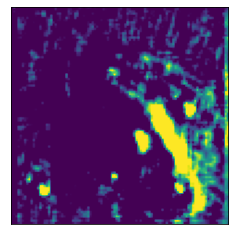

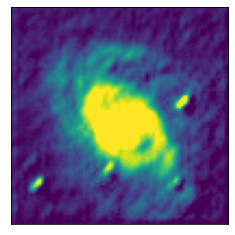

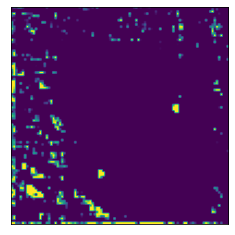

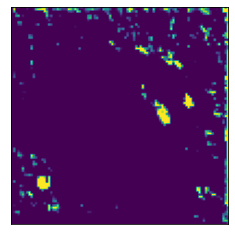

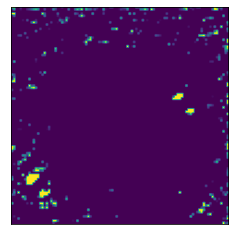

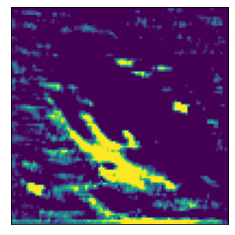

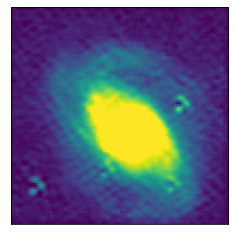

conv2d_3


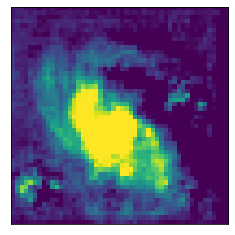

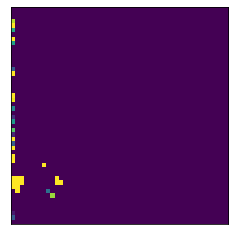

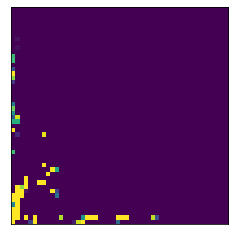

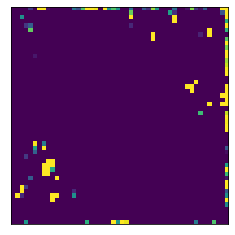

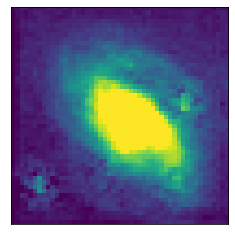

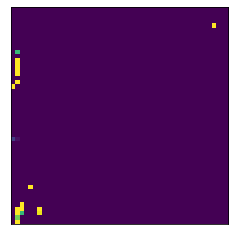

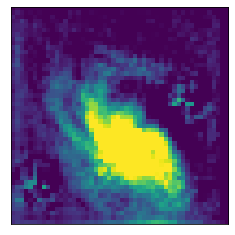

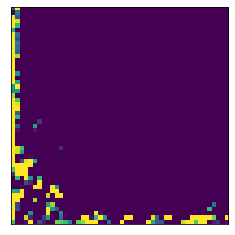

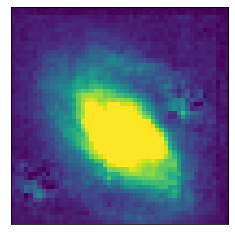

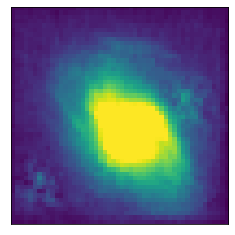

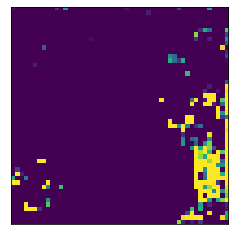

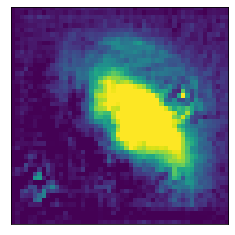

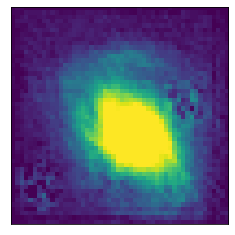

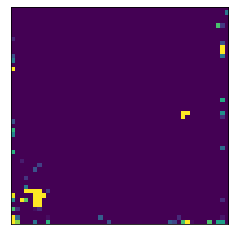

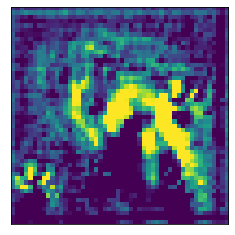

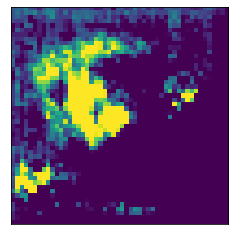

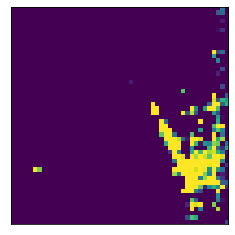

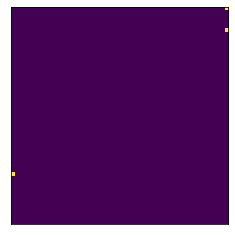

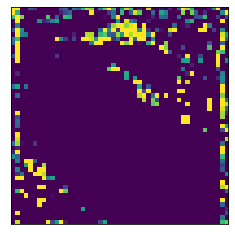

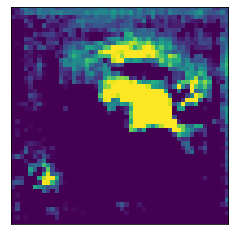

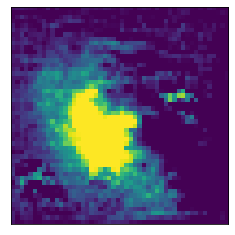

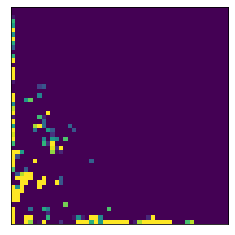

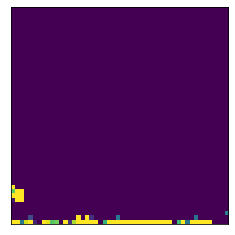

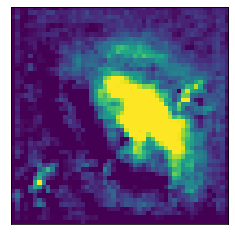

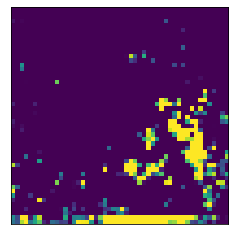

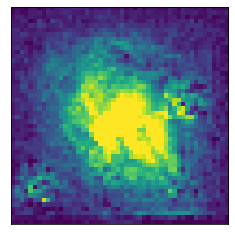

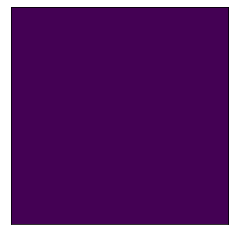

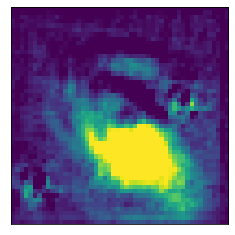

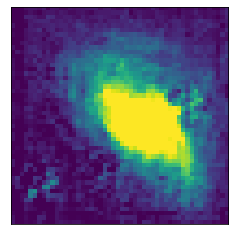

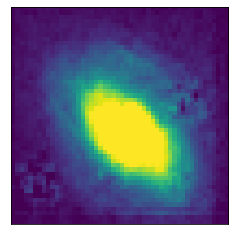

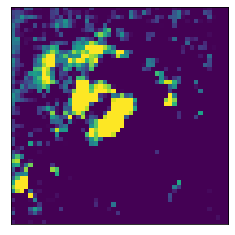

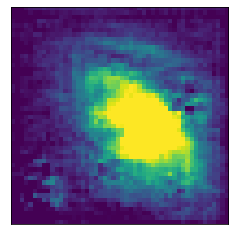

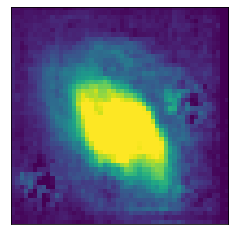

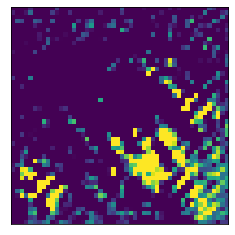

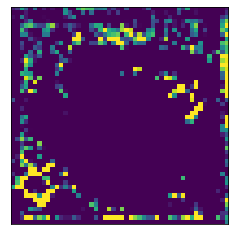

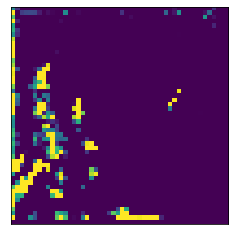

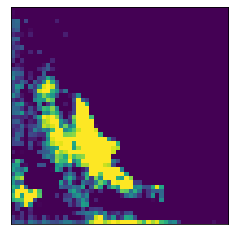

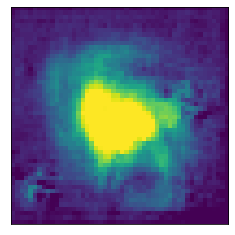

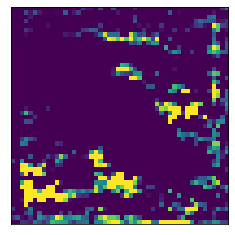

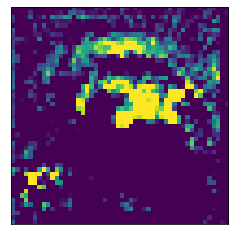

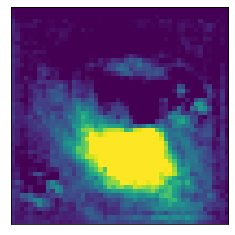

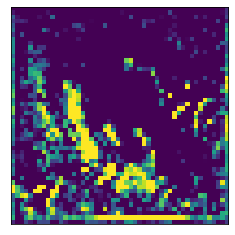

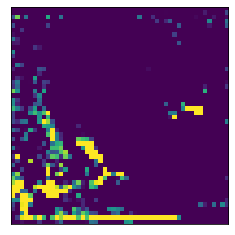

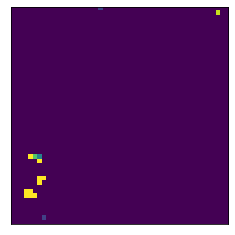

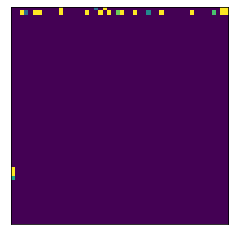

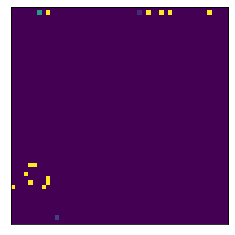

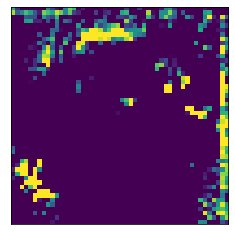

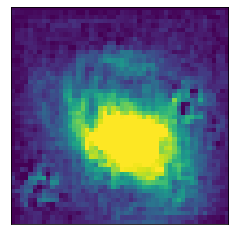

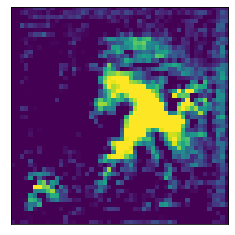

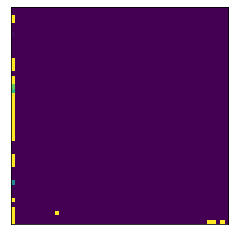

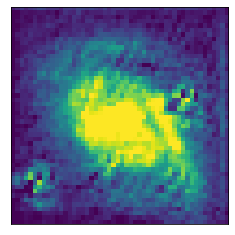

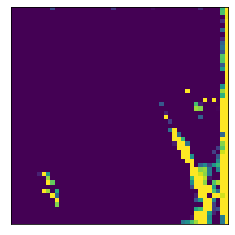

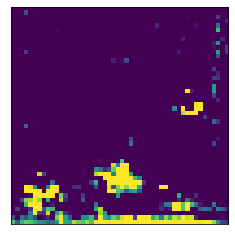

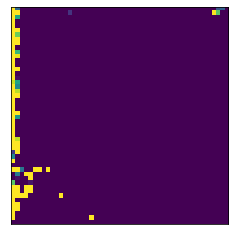

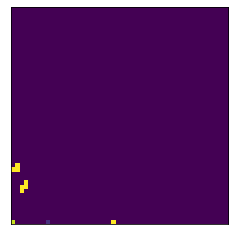

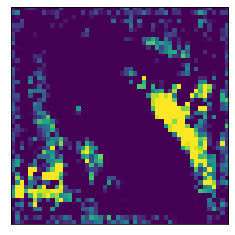

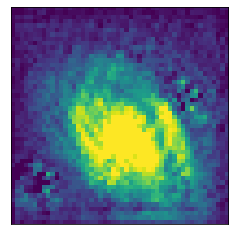

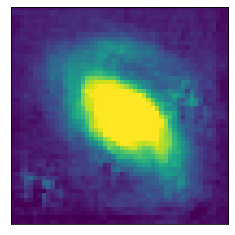

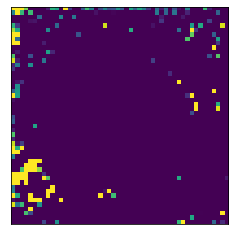

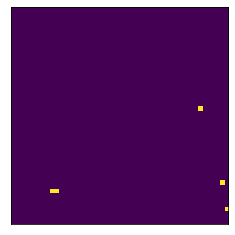

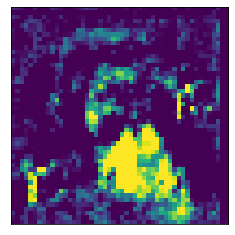

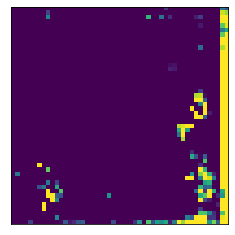

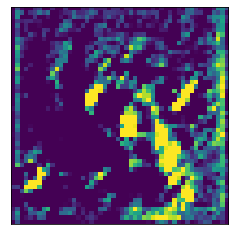

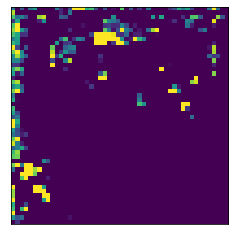

conv2d_4


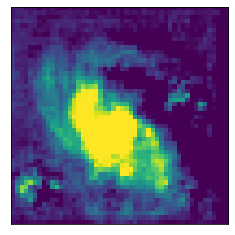

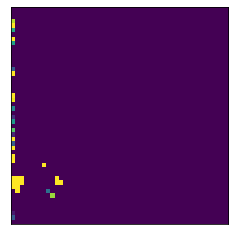

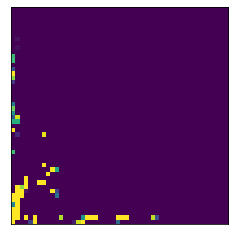

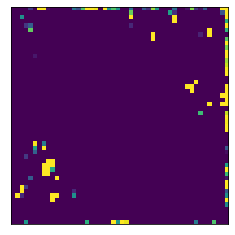

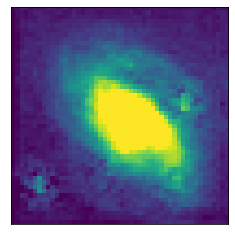

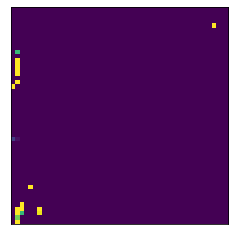

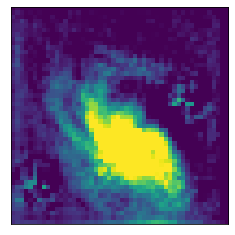

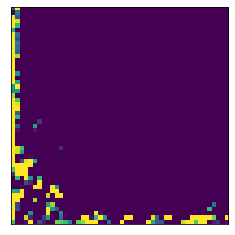

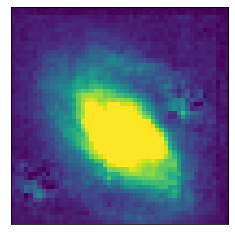

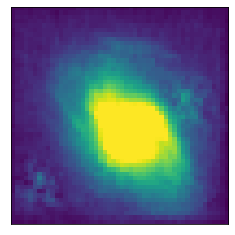

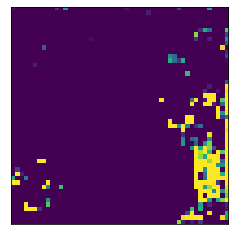

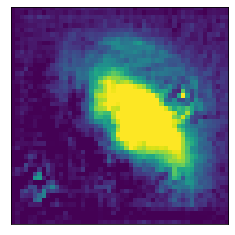

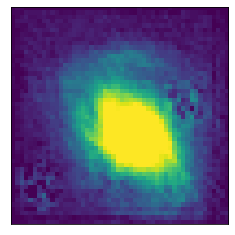

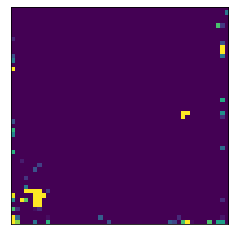

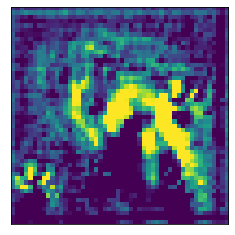

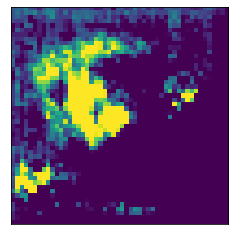

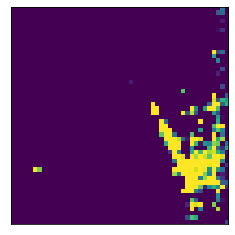

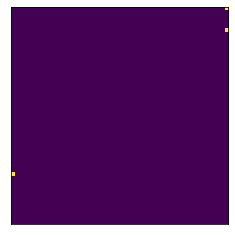

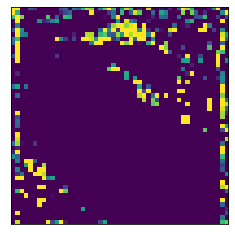

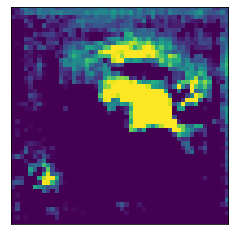

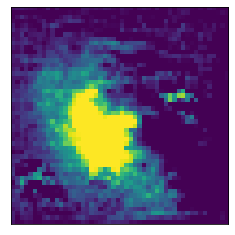

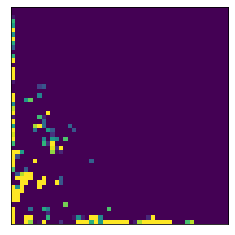

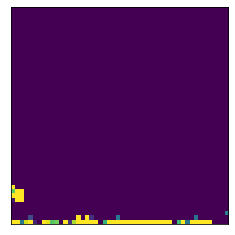

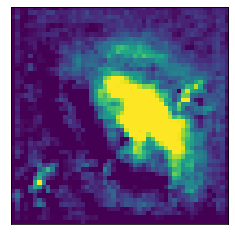

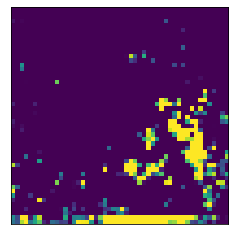

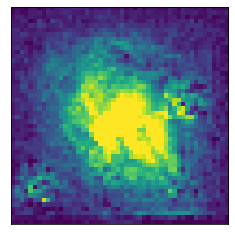

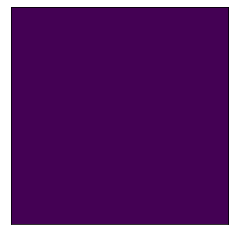

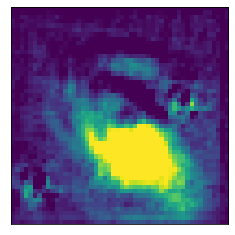

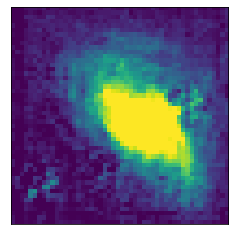

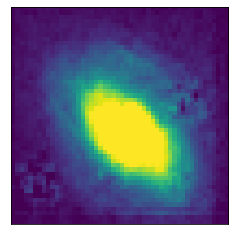

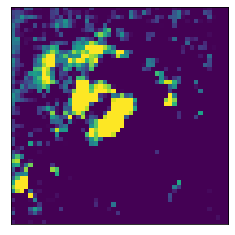

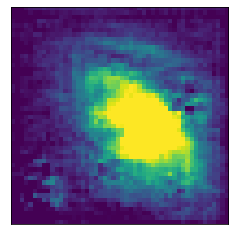

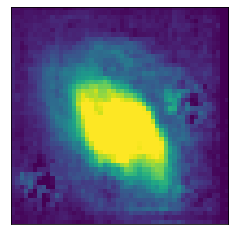

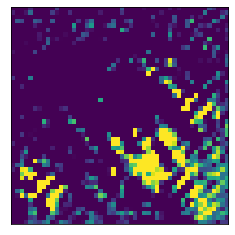

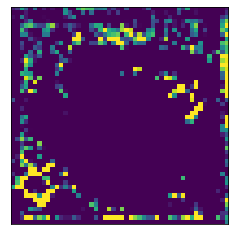

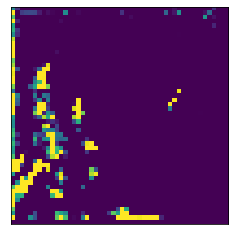

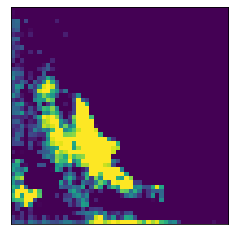

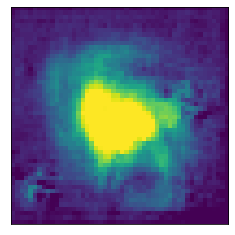

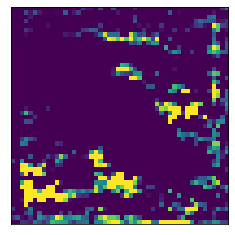

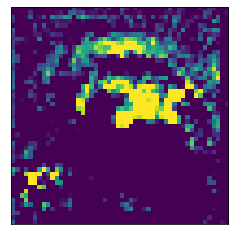

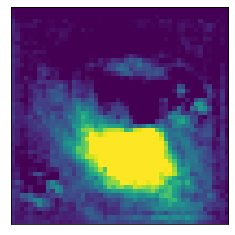

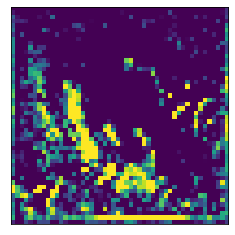

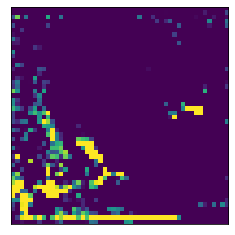

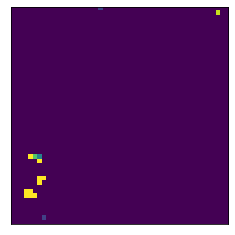

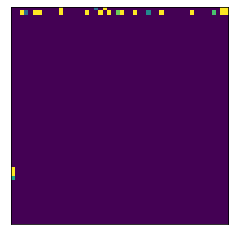

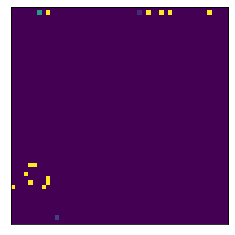

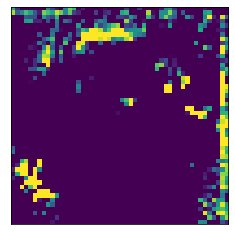

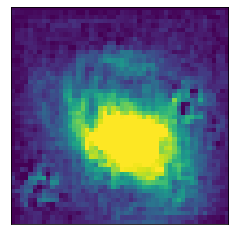

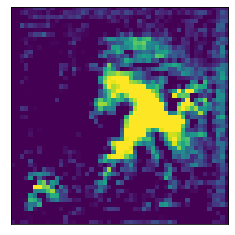

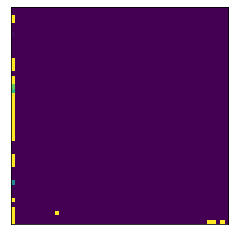

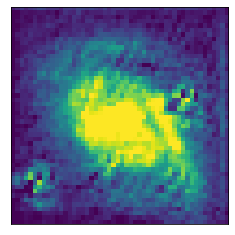

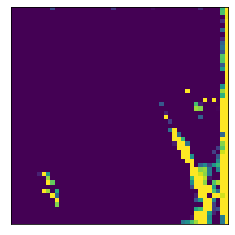

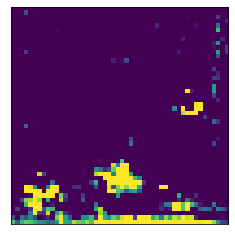

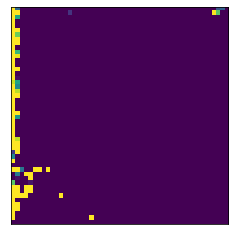

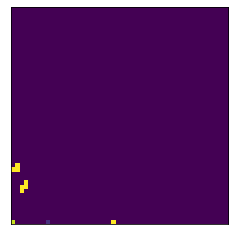

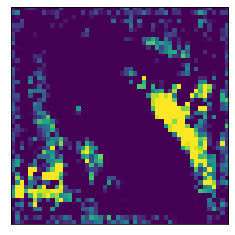

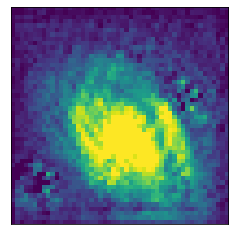

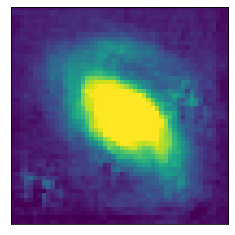

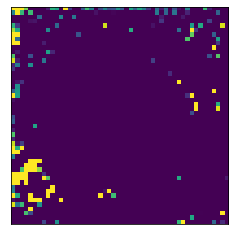

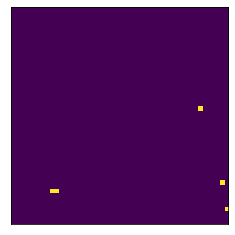

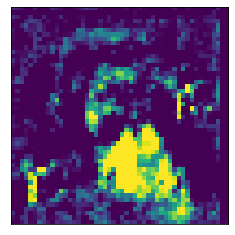

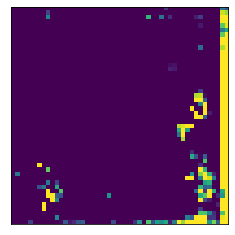

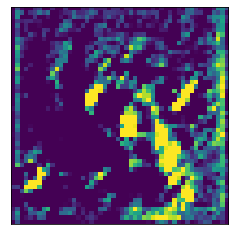

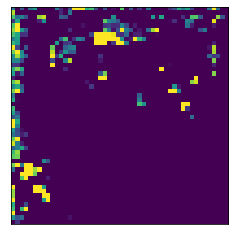

conv2d_5


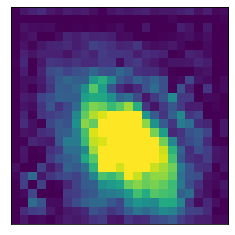

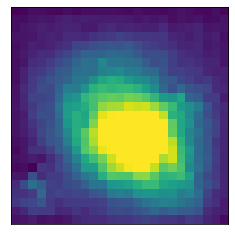

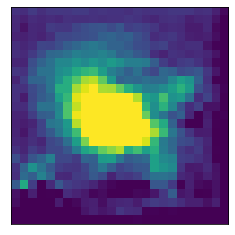

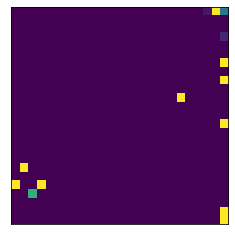

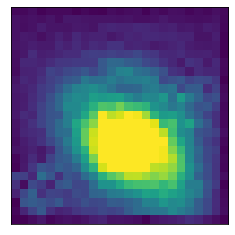

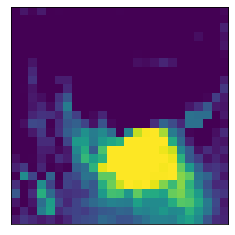

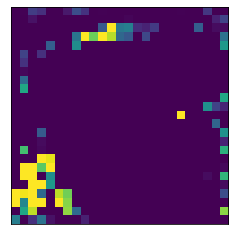

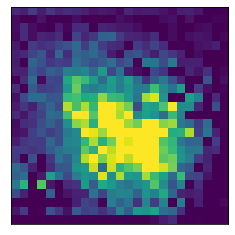

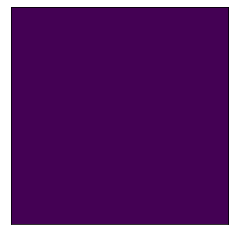

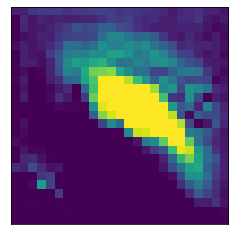

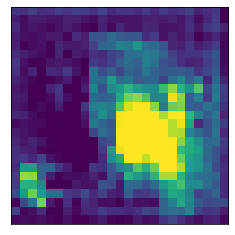

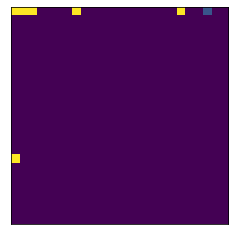

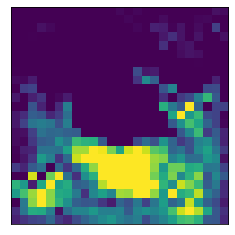

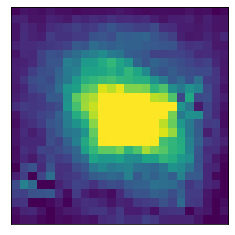

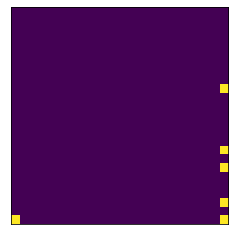

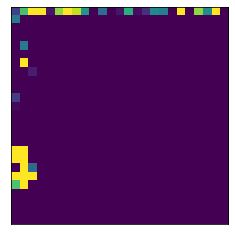

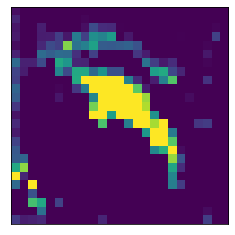

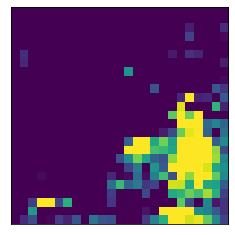

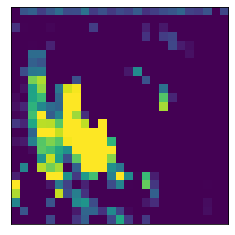

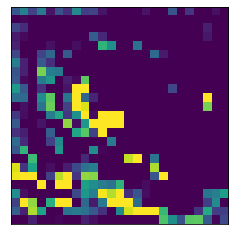

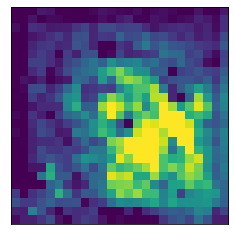

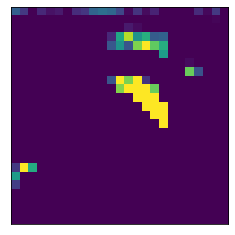

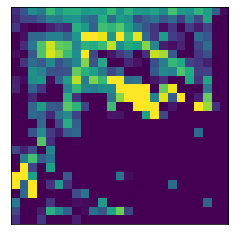

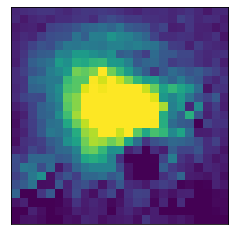

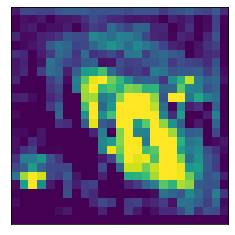

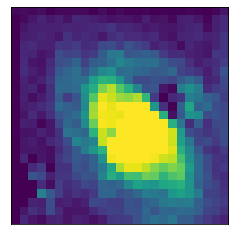

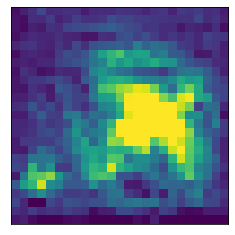

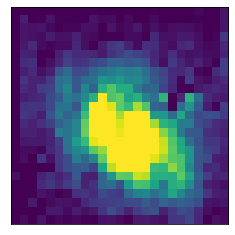

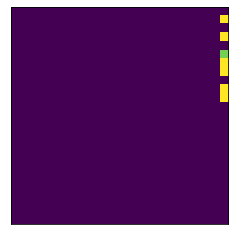

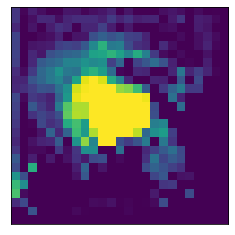

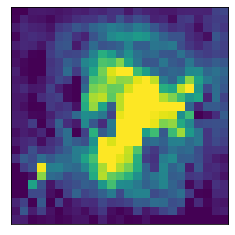

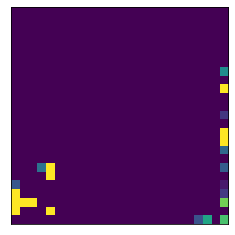

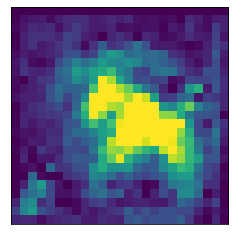

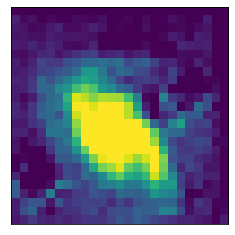

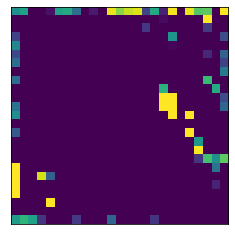

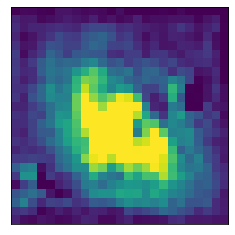

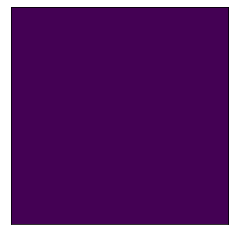

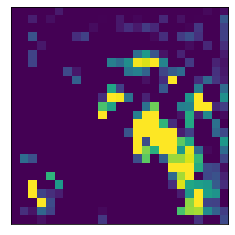

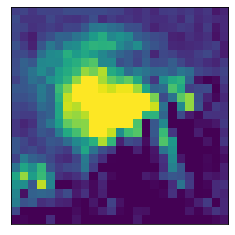

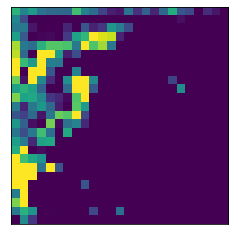

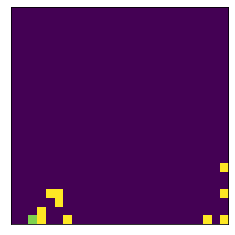

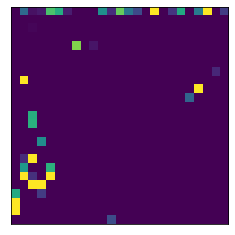

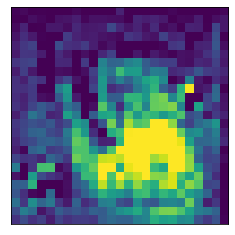

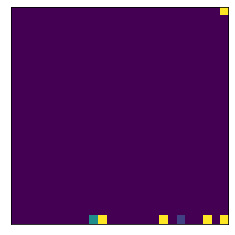

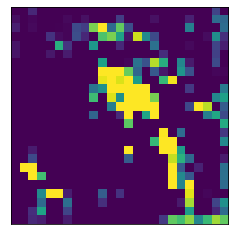

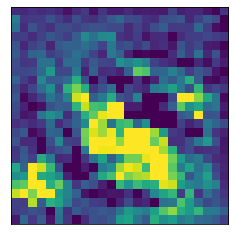

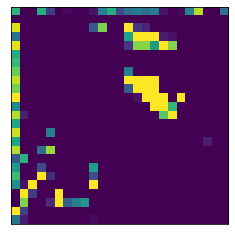

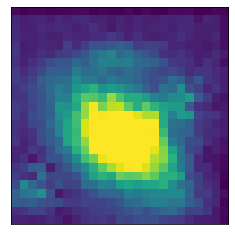

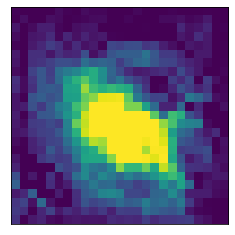

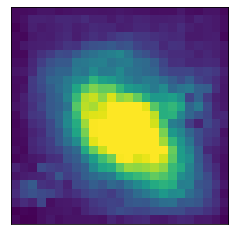

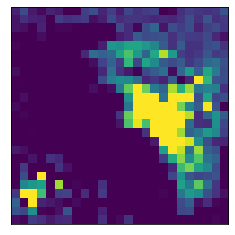

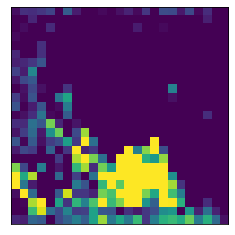

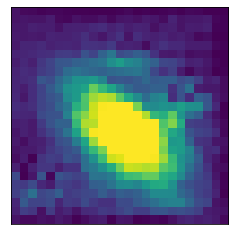

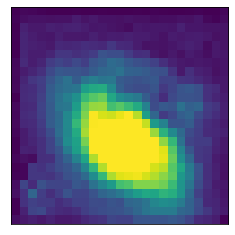

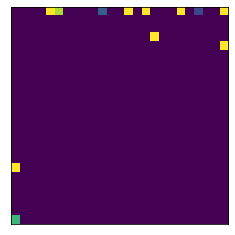

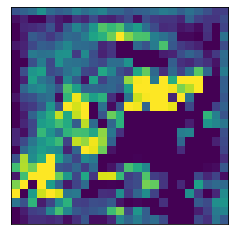

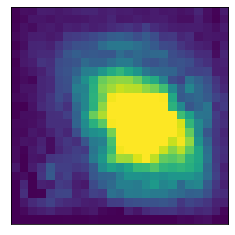

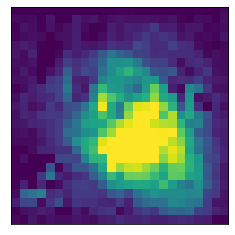

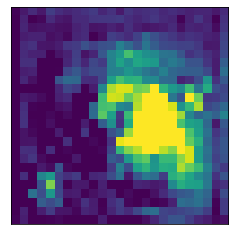

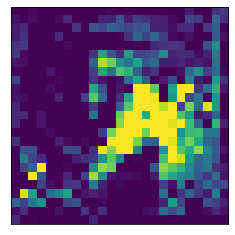

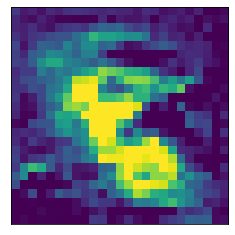

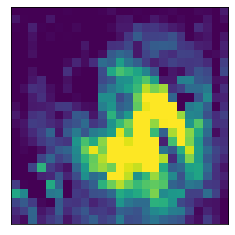

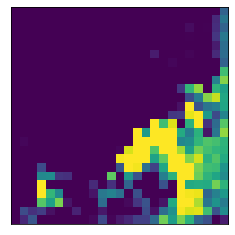

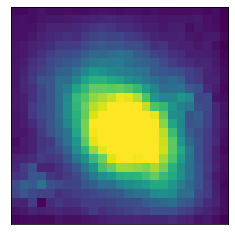

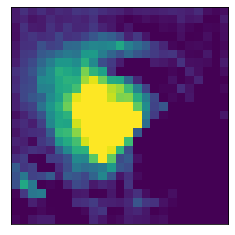

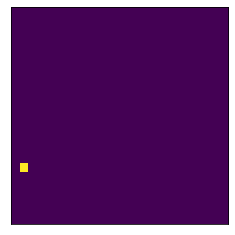

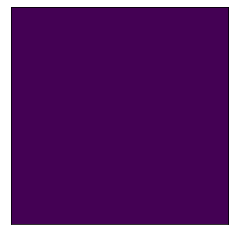

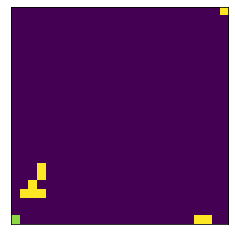

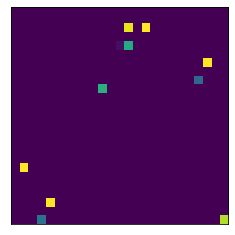

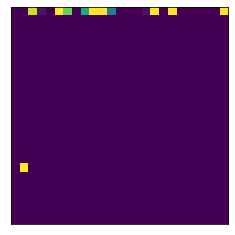

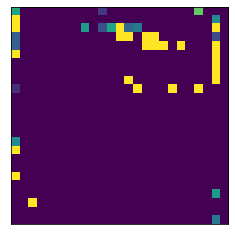

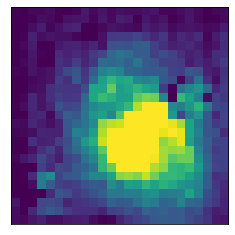

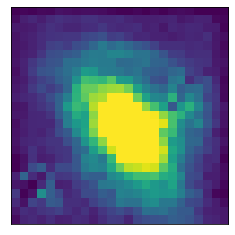

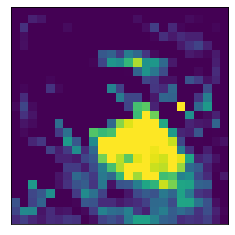

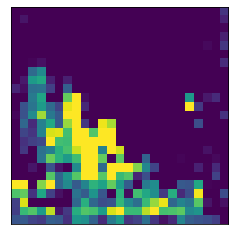

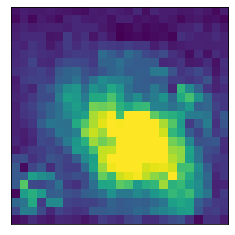

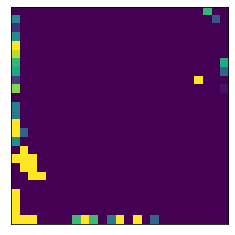

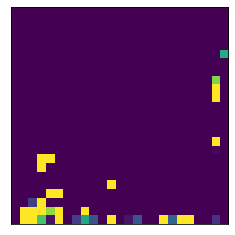

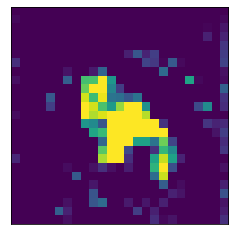

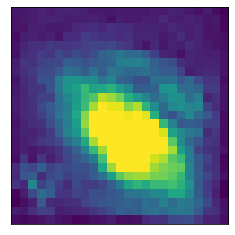

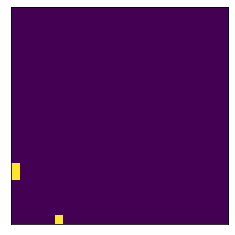

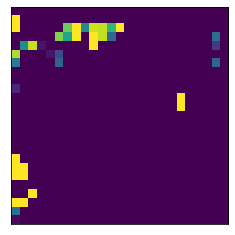

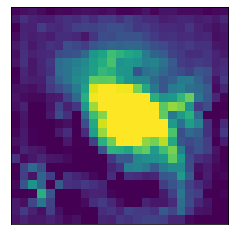

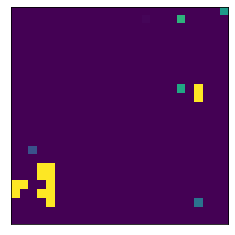

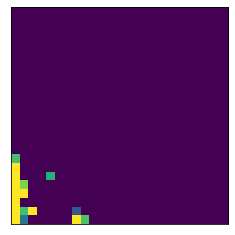

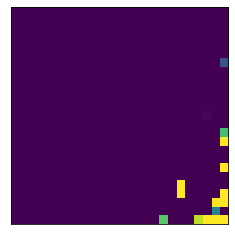

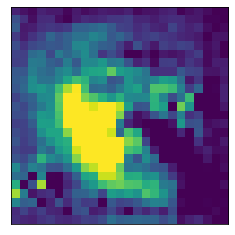

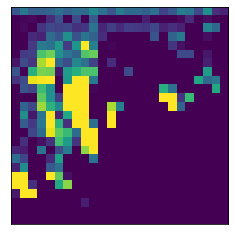

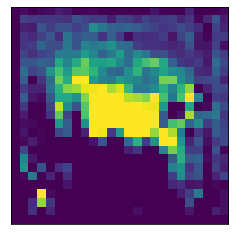

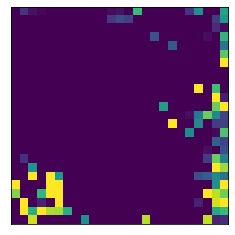

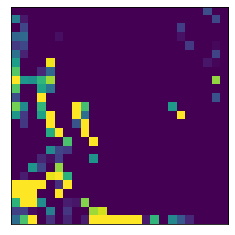

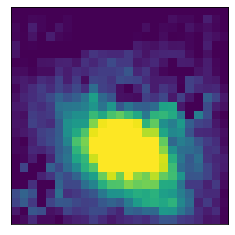

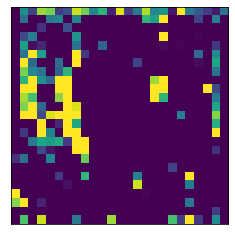

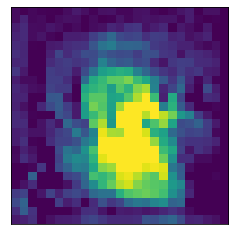

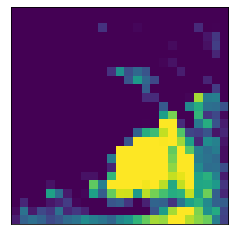

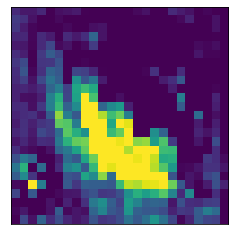

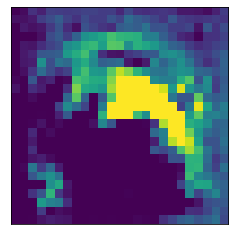

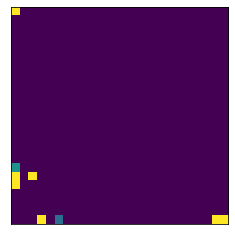

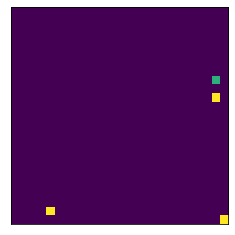

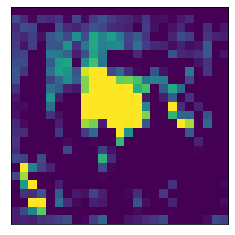

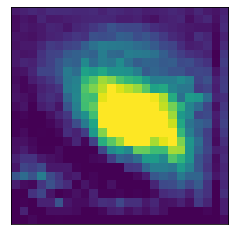

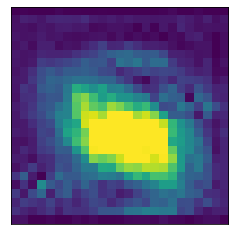

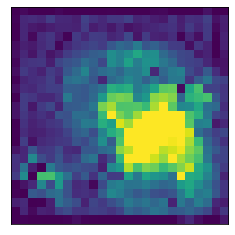

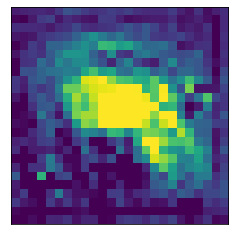

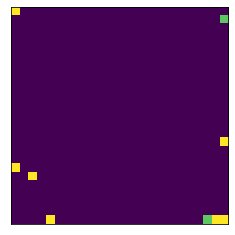

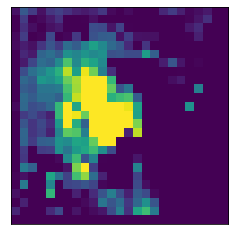

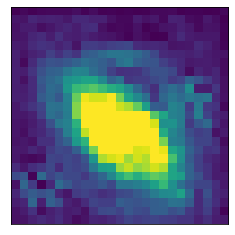

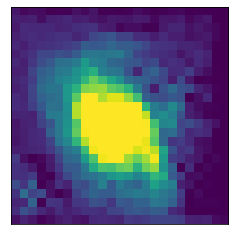

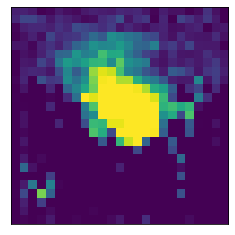

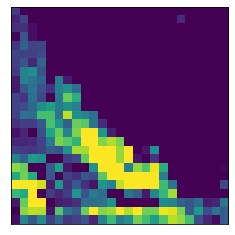

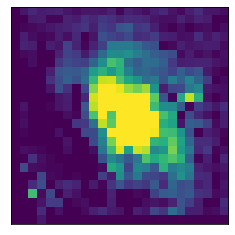

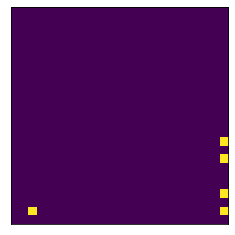

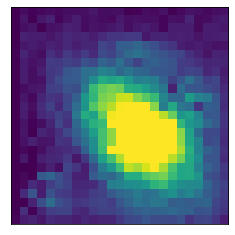

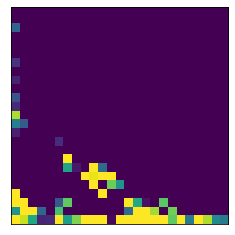

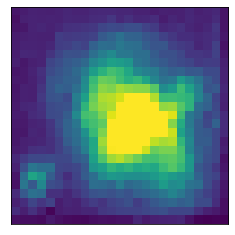

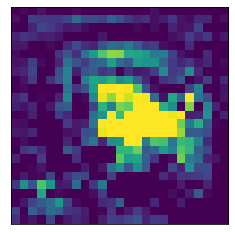

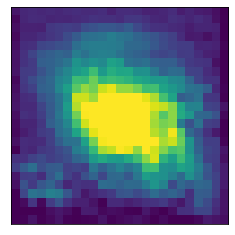

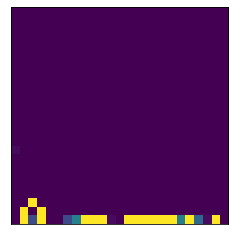

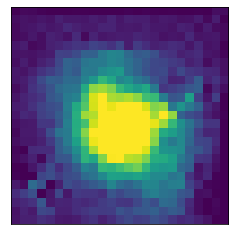

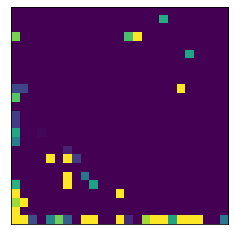

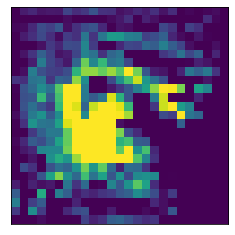

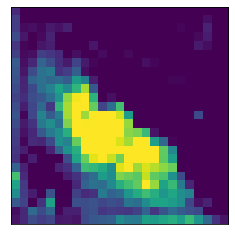

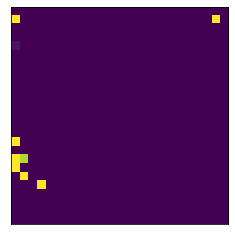

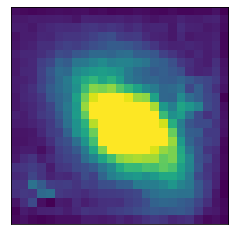

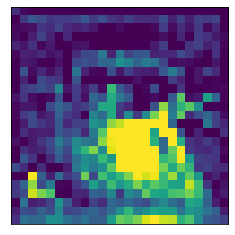

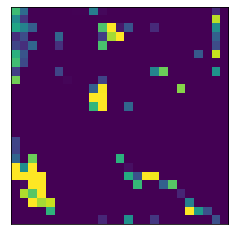

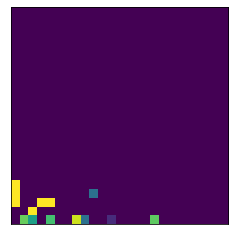

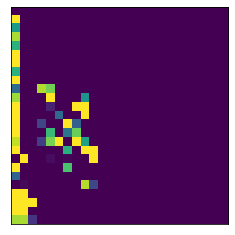

In [15]:
#Run this cell if you would like to have the individual images
#Saving the names of the lists of the images 
conv2d_list = []
conv2d1_list = []
conv2d2_list = []
conv2d3_list = []
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4 and ('conv2d' in layer_name):
        # We just want the maps for the conv layers, not the maxpool or fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
        # The images will be tiled in this matrix
        display_grid = np.zeros((size, size * n_features))

        # Altering the feature maps to be more visually understandable
        print(layer_name)
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8') #Saves the individual image
            display_grid[:, i * size : (i + 1) * size] = x # Combine all the maps into a long horizontal image
            #Saving the individual maps by layer
            if (layer_name == 'conv2d'):
                conv2d_list.append(x) #Takes the individual maps for the layer
                plt.xticks([])
                plt.yticks([])
                plt.imshow( x, aspect=1, cmap='viridis' )
                plt.show()
            if (layer_name == 'conv2d_1'):
                conv2d1_list.append(x)
                plt.xticks([])
                plt.yticks([])
                plt.imshow( x, aspect=1, cmap='viridis' )
                plt.show()
            #These bottom are for C2, above is for C1
            if (layer_name == 'conv2d_2'):
                conv2d_list.append(x)
                plt.xticks([])
                plt.yticks([])
                plt.imshow( x, aspect=1, cmap='viridis' )
                plt.show()
            if (layer_name == 'conv2d_3'):
                conv2d1_list.append(x)
                plt.xticks([])
                plt.yticks([])
                plt.imshow( x, aspect=1, cmap='viridis' )
                plt.show()
            if (layer_name == 'conv2d_4'):
                conv2d2_list.append(x)
                plt.xticks([])
                plt.yticks([])
                plt.imshow( x, aspect=1, cmap='viridis' )
                plt.show()
            if (layer_name == 'conv2d_5'):
                conv2d3_list.append(x)
                plt.xticks([])
                plt.yticks([])
                plt.imshow( x, aspect=1, cmap='viridis' )
                plt.show()